# Backtester

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [1]:
import json as js
import numpy as np
import pandas as pd
from ta import *
try:
    from fastai.imports import *
    from fastai.structured import *
    from fastai.column_data import *
except ImportError:
    print('*** Failed importing fast.ai modules ***')


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_test_train(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        test_records_count = int(len(self.train) * (1-percent_split))
        self.test = self.train.tail(test_records_count)
        self.train = self.train.head(train_records_count)
        self.test = self.test.set_index('Timestamp')
        self.train = self.train.set_index('Timestamp')
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close, weighted_price):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close],
            'Weighted_Price': self.train[weighted_price]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close', 'Weighted_Price']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # ////// FEATURE CREATION ///////
    # ///////////////////////////////

    def get_train_size(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        print('Train size: ' + str(train_records_count) +
              ' percent_split: ' + str(percent_split))
        return train_records_count

    def get_validation_indexes(self, train_size, df):
        validation_indexes = list(range(train_size, len(df)))
        print('Validation Index size: ' + str(len(validation_indexes)))
        return validation_indexes

    def apply_variable_types(self, df, cat_vars, contin_vars, dep):
        dep_array = [] if dep is None else [dep]
        df = df[cat_vars + contin_vars + dep_array].copy()
        for v in cat_vars:
            df[v] = df[v].astype('category').cat.as_ordered()
        for v in contin_vars:
            df[v] = df[v].astype('float32')
        return df

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def get_max_lookahead(self, df, target, lookahead):
        return df[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]

    def get_last_lookahead(self, df, target, lookahead):
        return df[target].shift(-lookahead)

    def get_lookback(self, df, target, lookback):
        return df[target].shift(lookback)

    def add_historical_candles(self, df, lookback):
        for i in range(1, lookback):
            df[str(i) + 'Open'] = self.get_lookback(df,
                                                    'Open', i).astype('float')
            df[str(i) + 'High'] = self.get_lookback(df,
                                                    'High', i).astype('float')
            df[str(i) + 'Low'] = self.get_lookback(df,
                                                   'Low', i).astype('float')
            df[str(i) + 'Close'] = self.get_lookback(df,
                                                     'Close', i).astype('float')
            df[str(i) + 'Volume'] = self.get_lookback(df,
                                                      'Volume', i).astype('float')

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.add_historical_candles(self.train, 30)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1
        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2
        self.train.action = self.train.action.astype(np.float32)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self, path):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self, PATH):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


*** Failed importing fast.ai modules ***


In [2]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
        if right_on is None:
            right_on = left_on
        return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                          suffixes=("", suffix))

## Config


In [3]:
np.set_printoptions(threshold=50, edgeitems=20)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from IPython.display import HTML

In [4]:
lookahead = 8
sample_size=100000
percentIncrease = 1.002
index='Timestamp'
# index='time_period_start'
dep = 'action'
PATH='../data/stock/'

## Create datasets

In [5]:
table_names = [
#         'btc-bitstamp-2012-01-01_to_2018-01-08'
#     'BTC_COINBASE_2018-07-25_09-06'
#     'ETH_COINBASE_07-21_08-24'
#     'COINBASE_BCH_2018-06-15_09-01'
#     'COINBASE_BTC_2017-11-01_01-09'
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27'
#     'bitstamp_07-09'
]

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
# for t in tables: display(t.head())

In [8]:
train= tables[0]

In [9]:
p = StockPredictor(train, index)
p.sample_train(sample_size)
# p.train = p.train.head(100000)
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
p.train

Train size: 100000 Original size: 1819074


,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1719074,1524057660,3.028865,8094.00,8094.01,8093.91,8093.91,8094.001822
1719075,1524057720,2.621265,8093.91,8094.01,8093.91,8094.00,8094.003435
1719076,1524057780,31.465237,8094.01,8094.78,8080.00,8083.22,8087.524921
1719077,1524057840,3.052776,8083.23,8083.23,8082.08,8082.08,8082.741258
1719078,1524057900,8.326656,8082.08,8086.48,8082.08,8086.47,8083.004706
1719079,1524057960,3.179333,8086.47,8089.99,8086.47,8086.48,8088.748944
1719080,1524058020,0.570207,8086.47,8086.47,8085.76,8085.77,8085.927870
1719081,1524058080,2.848367,8085.76,8088.00,8085.76,8087.99,8087.786360
1719082,1524058140,0.254200,8087.99,8088.00,8087.99,8088.00,8087.999213
1719083,1524058200,3.615644,8087.99,8090.00,8087.99,8090.00,8088.640443


## Change Point Analysis Setup

In [10]:
# $ pip3 install ruptures
import ruptures as rpt
import matplotlib.pyplot as plt

In [11]:
signal_df = pd.DataFrame({
    'Close':p.train.Close,
    'Volume':p.train.Volume
})[['Close','Volume']]
signal = signal_df.values

#### Binary Segmentation

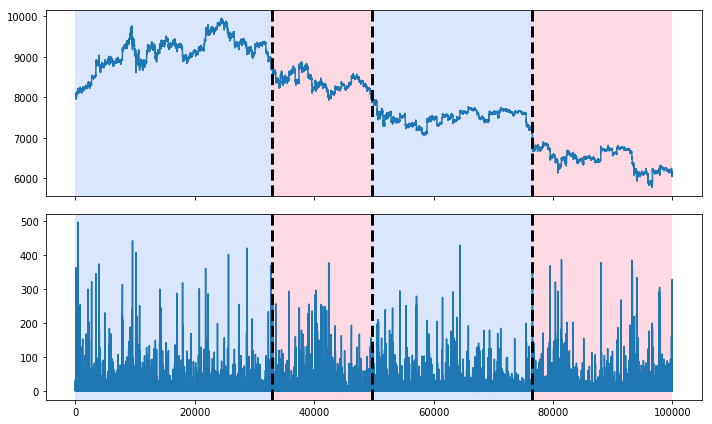

In [12]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()

#### Window Based

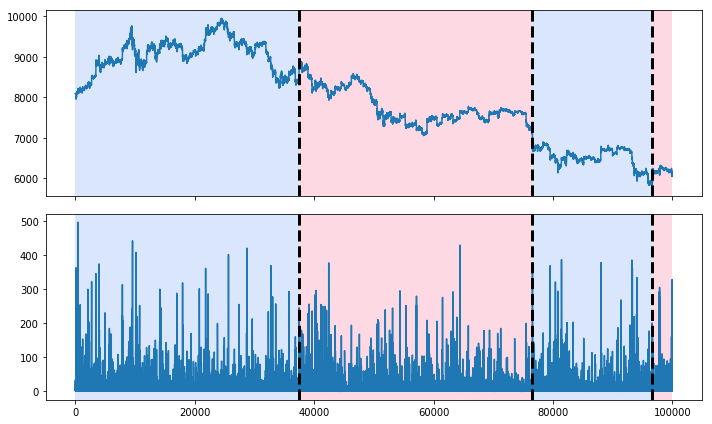

In [13]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=40, model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, my_bkps, my_bkps, figsize=(10, 6))
plt.show()